In [2]:
import pandas as pd
import os
import numpy as np
from dotenv import load_dotenv
import ast
import glob
import pingouin as pg

load_dotenv()

data_folder = os.getenv("DATA_FOLDER")

file_prefix = 'label_data'

# Use glob to find all CSV files with the given filename start
file_list = glob.glob(f"{data_folder}/{file_prefix}*.csv")

# Read each file into a DataFrame and concatenate them into a single DataFrame
dataframes = [pd.read_csv(file, sep=";",index_col=0) for file in file_list]
df = pd.concat(dataframes, ignore_index=True)

Testing for faulty labels

In [3]:
faulty_labels = 0
def safe_literal_eval(x):
    global faulty_labels
    try:
        return ast.literal_eval(x)
    except:
        faulty_labels += 1

df['Labels'] = df['Labels'].apply(safe_literal_eval)
print(faulty_labels)

101


## Statistical Analysis of NewsGuard scores (before Transformation)

In [4]:
df = df[df['Category'] != 'Coul']

In [5]:
df.groupby('Category')['avg_score'].describe() 

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,420.0,86.607946,14.821564,15.555556,84.705357,92.113095,95.232955,100.0
True,359.0,83.667999,17.965217,5.000000,82.500000,90.000000,93.880952,100.0


In [6]:
pg.normality(data=df, dv='avg_score', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'avg_score'],
                y=df.loc[df['Category'] == 'True', 'avg_score'],
                alternative='greater') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,85611.5,greater,0.000547,0.135582,0.567791


Rerunning the analysis for only the non-NaN label values

In [7]:
df = df[df['Labels'].notna()]

In [8]:
df.groupby('Category')['avg_score'].describe() 

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,368.0,86.641955,14.599342,15.555556,85.000000,92.083333,95.0000,100.0
True,330.0,85.077213,15.746573,5.000000,83.517857,90.217857,94.1125,100.0


In [9]:
pg.normality(data=df, dv='avg_score', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'avg_score'],
                y=df.loc[df['Category'] == 'True', 'avg_score'],
                alternative='greater') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,67620.0,greater,0.004739,0.113636,0.556818


In [10]:
# placeholder_ng_score = df['avg_score'].median()
# placeholder_ng_score

## Feature Extraction

This is the main function for extracting and calculating the features for analysis.

In [11]:
def retrieve_params(label_dict_list, positions=False, headlines=False):
    #create three distinct lists to control each parameter
    # if label_dict_list is empty return NaN
    if not label_dict_list:
        return np.nan
    article_stances = []
    article_ng_scores = []
    article_serp_positions = []
    
    for article in label_dict_list: #this is the search level; here we can retrieve SERP position and Newsguard score
        if not article: #catch empty entries
            continue
        if len(article['comparisons']) == 0:
               continue
        #retrieve variables
        serp_newsguard = article['serp_newsguard']
        serp_position = article['serp_position']

        #add to lists for decomposed calculation
        article_ng_scores.append(serp_newsguard)
        article_serp_positions.append(serp_position)

        article_stance = 0
        for claim_pair in article['comparisons']: #this is the "article level"; here we can retrieve relative claim position and the bool headline info
            relation = claim_pair['relation']

            if relation == 0: #skip calculation logic for unrelated claims
                continue

            try:
                #retrieve relative claim positions
                fm_claim_position = claim_pair['fm_claim_position']
                serp_claim_position = claim_pair['serp_claim_position']

                #retrieve headline bool
                fm_claim_headline = claim_pair['fm_claim_headline']
                serp_claim_headline = claim_pair['serp_claim_headline']

            except:
                pass

            if not positions and not headlines: #calculate article stance only based on relation
                article_stance += relation
            if positions and not headlines: #calculate article stance based on relation and position
                if relation in [-1, 1]:
                    if serp_claim_position < fm_claim_position: #if serp claim earlier in the article than the respective fm claim
                        article_stance += relation + (serp_claim_position - fm_claim_position) if relation == -1 else relation - (serp_claim_position - fm_claim_position) #e.g. -1 - dif else 1 + dif (reinforcing in each direction)
                    else: # if serp claim later in article than the respective fm claim
                        article_stance += relation - (fm_claim_position - serp_claim_position) if relation == -1 else relation + (fm_claim_position - serp_claim_position) #e.g. - 1 + dif else 1 - dif (weakening in each direction)
            if positions and headlines:
                if relation in [-1, 1]:
                    individual_stance = 0
                    if serp_claim_position < fm_claim_position: #if serp claim earlier in the article than the respective fm claim
                        individual_stance = relation + (serp_claim_position - fm_claim_position) if relation == -1 else relation - (serp_claim_position - fm_claim_position) #e.g. -1 - dif else 1 + dif (reinforcing in each direction)
                        if serp_claim_headline:
                            individual_stance *= 2
                    else: # if serp claim later in article than the respective fm claim
                        individual_stance = relation - (fm_claim_position - serp_claim_position) if relation == -1 else relation + (fm_claim_position - serp_claim_position) #e.g. - 1 + dif else 1 - dif (weakening in each direction)
                        if serp_claim_headline:
                                individual_stance *= 2
                    article_stance += individual_stance
            if headlines and not positions:
                article_stance += relation * serp_claim_headline 
        if headlines and not positions:
            article_stances.append(article_stance/len(article['comparisons']))
        else:
            article_stances.append(article_stance/len(article['comparisons']))

    #if article_stances could not be successfully retrieved, return NaN
    if not article_stances:
        return np.nan
    
    article_ng_scores = np.array(article_ng_scores, dtype=float)
    # article_ng_scores = np.nan_to_num(article_ng_scores, nan=placeholder_ng_score) 

    return {'article_stances': article_stances, 'article_ng_scores': article_ng_scores, 'article_serp_positions': article_serp_positions}

Extracting the features based on different configs

In [12]:
df['Features_Raw']= df['Labels'].apply(retrieve_params)
df['Features_Pos']= df['Labels'].apply(lambda x: retrieve_params(x, positions=True, headlines=False))
df['Features_H']= df['Labels'].apply(lambda x: retrieve_params(x, positions=False, headlines=True))
df['Features_HP']= df['Labels'].apply(lambda x: retrieve_params(x, positions=True, headlines=True))

In [13]:
df = df[df['Features_Raw'].notna()]

In [14]:
df

,Article_day,ResponseId,Day,Category,True_Dummy,Seven_Ordinal,Four_Ordinal,Age,Gender,FC_Eval,...,avg_score,list_domains,list_scores,all_clean_urls,newsguard_dict,Labels,Features_Raw,Features_Pos,Features_H,Features_HP
1,Day_1_1,R_1Gv8iAs1HEqGuUe,Day_1,Misl,0,1,1,35,1,FM,...,95.277778,"abc15.com', 'salon.com', 'cnn.com', 'politico....","100,87.5,87.5,100,95,95,100,100,92.5",('https://www.abc15.com/news/state/poll-many-r...,"{'abc15.com': 100, 'salon.com': 87.5, 'cnn.com...","[{}, {}, {}, {}, {}, {}, {}, {}, {}, {'compari...","{'article_stances': [0.0], 'article_ng_scores'...","{'article_stances': [-0.011111111111111125], '...","{'article_stances': [0.0], 'article_ng_scores'...","{'article_stances': [-0.011111111111111125], '..."
2,Day_1_1,R_1Gv8iAs1HEqGuUe,Day_1,Misl,0,1,1,35,1,FM,...,83.450000,"cnn.com', 'thehill.com', 'salon.com', 'washing...","87.5,80,87.5,42,87.5,100,92.5,87.5,85,85",('https://www.cnn.com/2021/07/18/politics/fact...,"{'cnn.com': 87.5, 'thehill.com': 80, 'salon.co...","[{'comparisons': [{'claim_article_a': ""Arizona...","{'article_stances': [-0.2, 0.08, -0.12, 0.0], ...","{'article_stances': [-0.20393939393939392, 0.2...","{'article_stances': [0.0, 0.2, 0.0, 0.0], 'art...","{'article_stances': [-0.20393939393939392, 0.4..."
3,Day_1_1,R_3KT6q7Vntwvmg8Z,Day_1,True,1,7,3,33,1,FM,...,92.812500,"thehill.com', 'recorder.maricopa.gov', 'washin...","80,100,100,100,100,92.5,75,95",('https://thehill.com/homenews/campaign/563100...,"{'thehill.com': 80, 'recorder.maricopa.gov': 1...","[{}, {}, {'comparisons': [{'claim_article_a': ...","{'article_stances': [0.24, 0.4, 0.12, 0.4, 0.2...","{'article_stances': [0.2829512516469038, 0.475...","{'article_stances': [0.0, 0.2, 0.0, 0.2, 0.0, ...","{'article_stances': [0.2829512516469038, 0.745..."
4,Day_1_1,R_1Gv8iAs1HEqGuUe,Day_1,Misl,0,1,1,35,1,FM,...,96.000000,"apnews.com', 'detroitnews.com', 'cnn.com', 'ap...","95,92.5,87.5,95,95,100,100,100,100,95",('https://apnews.com/article/technology-joe-bi...,"{'apnews.com': 95, 'detroitnews.com': 92.5, 'c...","[{}, {}, {'comparisons': [{'claim_article_a': ...","{'article_stances': [-0.2, -0.8, -0.28, -1.0, ...","{'article_stances': [-0.20393939393939392, -1....","{'article_stances': [0.0, -0.8, 0.12, -0.2, -0...","{'article_stances': [-0.20393939393939392, -2...."
6,Day_1_1,R_3LXaF7Z7z740d2k,Day_1,Misl,0,1,1,26,1,FM,...,70.500000,"westernjournal.com', 'newsweek.com', 'flipboar...","82,100,12.5,87.5",('https://www.westernjournal.com/az-state-sena...,"{'westernjournal.com': 82, 'newsweek.com': 100...","[{'comparisons': [{'claim_article_a': ""Arizona...","{'article_stances': [0.16, -0.16], 'article_ng...","{'article_stances': [0.1693333333333333, -0.08...","{'article_stances': [0.04, 0.04], 'article_ng_...","{'article_stances': [0.20954545454545453, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954,Day_9_3,R_2QEWqk6A2nnsg7O,Day_9,True,1,6,4,26,0,FM,...,91.666667,"cnn.com', 'cnn.com', 'cnn.com', 'cnn.com', 'cn...","87.5,87.5,87.5,87.5,87.5,87.5,100,100,100",('https://www.cnn.com/videos/us/2021/10/25/nih...,"{'cnn.com': 87.5, 'npr.org': 100, 'nytimes.com...","[{'comparisons': [{'claim_article_a': ""The NIH...","{'article_stances': [1.0], 'article_ng_scores'...","{'article_stances': [1.3117647058823534], 'art...","{'article_stances': [1.0], 'article_ng_scores'...","{'article_stances': [2.6235294117647068], 'art..."
955,Day_9_3,R_3P7x5JWi3Xcbsqi,Day_9,True,1,7,4,25,1,FM,...,90.000000,"nih.gov', 'nih.gov', ''', 'jacksonville.com', ...","82.5,82.5,100,95",('https://www.nih.gov/news-events/news-release...,{},"[{'comparisons': [{'claim_article_a': ""The NIH...","{'article_stances': [-0.12, -0.2], 'article_ng...","{'article_stances': [-0.1420211161387632, -0.2...","{'article_stances': [0.0, 0.0], 'article_ng_sc...","{'article_stances': [-0.1420211161387632, -0.2..."
956,Day_9_3,R_3JqGYdN07AFVzOf,Day_9,Misl,0,1,1,41,0,FM,...,98.437500,"factcheck.org', 'yahoo.com', 'theintercept.com...","100,100,8

# Additional Features for Exploration

## Label Transformation

In [15]:
label_mapping = {
    'Coul' : np.nan,
    'Misl' : 0,
    'True' : 1
}

df['User_Labels'] = df['Category'].map(label_mapping)

In [16]:
df = df[df['User_Labels'].notna()] #remove 'could' values

## Number of articles

In [17]:
def get_num_articles(label_lists):
    return sum(bool(d) for d in label_lists)

df['num_valid_articles'] = df['Labels'].apply(get_num_articles)

In [18]:
df['num_valid_articles'].describe()

count    595.000000
mean       3.242017
std        1.755774
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        9.000000
Name: num_valid_articles, dtype: float64

In [19]:
df.groupby('Category')['num_valid_articles'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,3.233333,1.705457,1.0,2.0,3.0,4.0,8.0
True,295.0,3.250847,1.808368,1.0,2.0,3.0,4.0,9.0


C:\Users\danie\AppData\Local\Temp\ipykernel_2152\2884463668.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, x='Value', y='Count', palette='Set1')


Text(0, 0.5, 'Frequency')

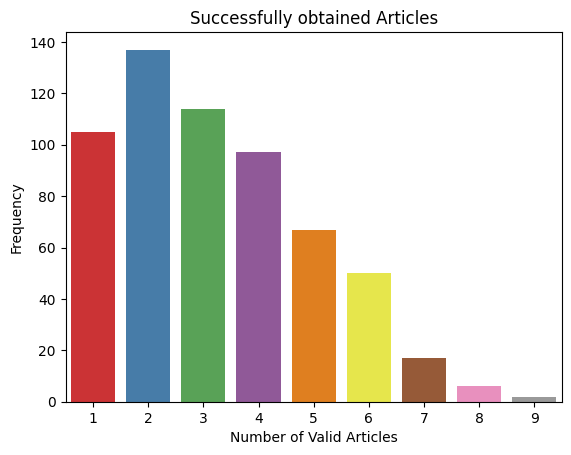

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = df['num_valid_articles'].value_counts().reset_index()
counts.columns = ['Value', 'Count']  # Rename columns for clarity

# Create the barplot
sns.barplot(data=counts, x='Value', y='Count', palette='Set1')
plt.title('Successfully obtained Articles')
plt.xlabel('Number of Valid Articles')
plt.ylabel('Frequency')

# Article Stances

## Raw Stances

In [21]:
#try different transformation methods

def transform_stances(feat_dict, method):
    if pd.isna(feat_dict):
        return np.nan
    stance_list = feat_dict['article_stances']
    return method(stance_list)

### Mean

In [22]:
df['Stances_Mean'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=np.mean))

In [23]:
df['Stances_Mean'].describe()

count    595.000000
mean       0.106813
std        0.253608
min       -1.000000
25%       -0.018000
50%        0.080000
75%        0.266667
max        1.000000
Name: Stances_Mean, dtype: float64

In [24]:
df.groupby('Category')['Stances_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,0.075238,0.236799,-0.866667,-0.048,0.026667,0.20,0.76
True,295.0,0.138922,0.266209,-1.000000,0.000,0.128000,0.32,1.00


In [25]:
import pingouin as pg
pg.normality(data=df, dv='Stances_Mean', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_Mean'],
                y=df.loc[df['Category'] == 'True', 'Stances_Mean'],
                alternative='less') #Mann-Whitney U (testing if Misl (Group 1) is less than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,36073.0,less,0.000047,-0.184791,0.592395


In [26]:
df.groupby('num_valid_articles')['Stances_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,105.0,0.147429,0.351888,-1.000000,0.000000,0.120000,0.440000,1.000000
2,137.0,0.113066,0.279699,-1.000000,0.000000,0.080000,0.320000,0.720000
3,114.0,0.101519,0.224328,-0.866667,-0.010000,0.080000,0.266667,0.520000
4,97.0,0.061874,0.169322,-0.450000,-0.040000,0.053333,0.170000,0.470000
5,67.0,0.109761,0.177236,-0.272000,-0.028000,0.112000,0.232000,0.544000
6,50.0,0.081053,0.224124,-0.460000,-0.083333,0.033333,0.240000,0.560000
7,17.0,0.098936,0.240454,-0.342857,-0.005714,0.057143,0.333333,0.422857
8,6.0,0.305929,0.154284,0.135000,0.170144,0.312788,0.406250,0.515000
9,2.0,0.042222,0.103709,-0.031111,0.005556,0.042222,0.078889,0.115556


C:\Users\danie\AppData\Local\Temp\ipykernel_2152\2511394612.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

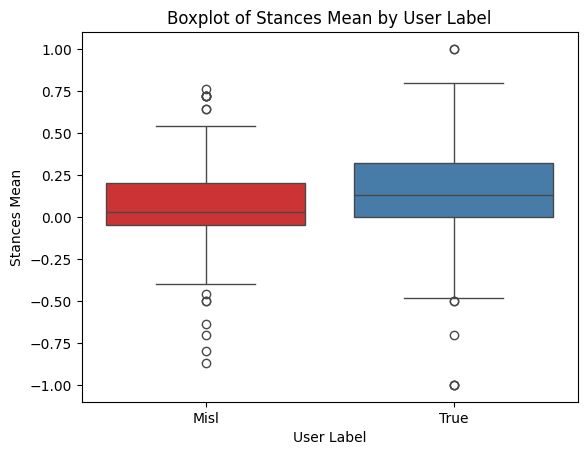

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='Category', y='Stances_Mean', palette='Set1')
plt.title('Boxplot of Stances Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

C:\Users\danie\AppData\Local\Temp\ipykernel_2152\3390867210.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='num_valid_articles', y='Stances_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

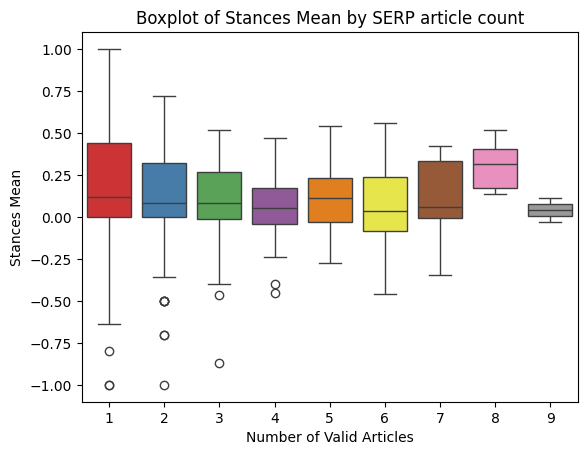

In [28]:
sns.boxplot(data=df, x='num_valid_articles', y='Stances_Mean', palette='Set1')
plt.title('Boxplot of Stances Mean by SERP article count')
plt.xlabel('Number of Valid Articles')
plt.ylabel('Stances Mean')

#### Last User Queries

In [29]:
last_search_df = df.drop_duplicates(subset='ResponseId', keep='last')
last_search_df.groupby('Category')['Stances_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,123.0,0.058543,0.240146,-0.866667,-0.088,0.03,0.200000,0.72
True,142.0,0.147195,0.279643,-1.000000,0.000,0.13,0.341143,1.00


C:\Users\danie\AppData\Local\Temp\ipykernel_2152\3509361157.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=last_search_df, x='Category', y='Stances_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

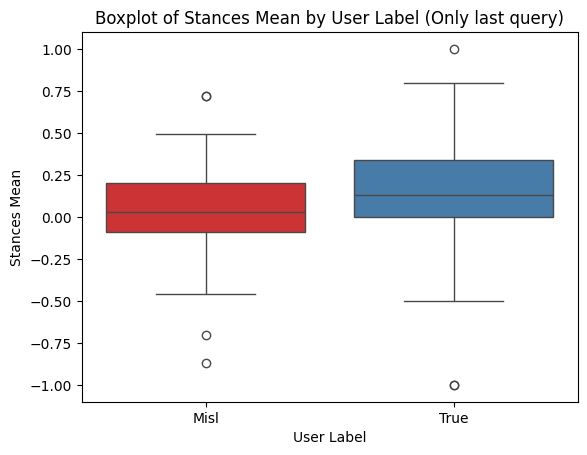

In [30]:
sns.boxplot(data=last_search_df, x='Category', y='Stances_Mean', palette='Set1')
plt.title('Boxplot of Stances Mean by User Label (Only last query)')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

### NDCG

In [31]:
from sklearn.metrics import ndcg_score

In [32]:
test_array = [0.5, 0.01, 0.3, -1, 1]

#transform values to fit between 0 and 1

def ndcg(stances):
    stances = np.array(stances)
    stances = (stances + 1) / 2  # Transform values from [-1, 1] to [0, 1]
    if len(stances) == 1:
        return np.nan
    true_relevance = np.array([stances])  
    relevance_score = np.array([sorted(stances, reverse=True)]) 
    print(true_relevance, relevance_score)

    return ndcg_score(true_relevance, relevance_score)
          
ndcg(test_array)

[[0.75  0.505 0.65  0.    1.   ]] [[1.    0.75  0.65  0.505 0.   ]]


np.float64(0.883307074205988)

In [33]:
df['Stances_NDCG'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=ndcg))

[[0.4  0.54 0.44 0.5 ]] [[0.54 0.5  0.44 0.4 ]]
[[0.62 0.7  0.56 0.7  0.6  0.5 ]] [[0.7  0.7  0.62 0.6  0.56 0.5 ]]
[[0.4  0.1  0.36 0.   0.16 0.6 ]] [[0.6  0.4  0.36 0.16 0.1  0.  ]]
[[0.58 0.42]] [[0.58 0.42]]
[[0.58       0.52       0.44642857 0.4       ]] [[0.58       0.52       0.44642857 0.4       ]]
[[0.58       0.52       0.44642857 0.4       ]] [[0.58       0.52       0.44642857 0.4       ]]
[[0.58 0.4  0.56]] [[0.58 0.56 0.4 ]]
[[0.58 0.4  0.56]] [[0.58 0.56 0.4 ]]
[[0.42 0.58]] [[0.58 0.42]]
[[0.42 0.5 ]] [[0.5  0.42]]
[[0.3  0.44 0.3  0.2  0.22 0.5  0.5 ]] [[0.5  0.5  0.44 0.3  0.3  0.22 0.2 ]]
[[0.42 0.5 ]] [[0.5  0.42]]
[[0.58 0.42]] [[0.58 0.42]]
[[0.42 0.5  0.38]] [[0.5  0.42 0.38]]
[[0.42 0.58 0.58]] [[0.58 0.58 0.42]]
[[0.4  0.38 0.4 ]] [[0.4  0.4  0.38]]
[[0.42 0.58]] [[0.58 0.42]]
[[0.42 0.52 0.62]] [[0.62 0.52 0.42]]
[[0.38 0.58]] [[0.58 0.38]]
[[0.2 0.5 0.5 0.3 0.5]] [[0.5 0.5 0.5 0.3 0.2]]
[[0.42 0.58 0.3 ]] [[0.58 0.42 0.3 ]]
[[0.5  0.7  0.42 0.4 ]] [[0.7  0.5  

In [34]:
df['Stances_NDCG'].describe()

count    481.000000
mean       0.962825
std        0.049394
min        0.630930
25%        0.942639
50%        0.979165
75%        1.000000
max        1.000000
Name: Stances_NDCG, dtype: float64

In [35]:
df.groupby('Category')['Stances_NDCG'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,243.0,0.962708,0.049040,0.63093,0.943011,0.981516,1.0,1.0
True,238.0,0.962944,0.049857,0.63093,0.942651,0.976208,1.0,1.0


In [36]:
df.groupby('num_valid_articles')['Stances_NDCG'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,128.0,0.978547,0.053396,0.630930,0.972465,1.000000,1.000000,1.000000
3,114.0,0.967973,0.048339,0.704431,0.952796,0.982022,1.000000,1.000000
4,97.0,0.960410,0.041277,0.768858,0.932317,0.975230,0.995061,1.000000
5,67.0,0.946564,0.051165,0.692736,0.929165,0.952884,0.983033,1.000000
6,50.0,0.948721,0.043370,0.805914,0.936017,0.955702,0.978902,1.000000
7,17.0,0.934183,0.044122,0.849172,0.911346,0.937351,0.961544,0.995230
8,6.0,0.959450,0.034678,0.915757,0.930386,0.969431,0.980891,1.000000
9,2.0,0.931193,0.020129,0.916960,0.924077,0.931193,0.938310,0.945426


C:\Users\danie\AppData\Local\Temp\ipykernel_2152\1980220825.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='num_valid_articles', y='Stances_NDCG', palette='Set1')


Text(0, 0.5, 'Stances Mean')

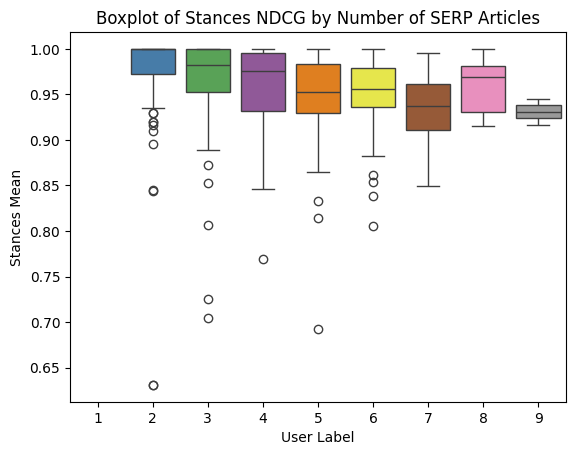

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='num_valid_articles', y='Stances_NDCG', palette='Set1')
plt.title('Boxplot of Stances NDCG by Number of SERP Articles')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

## First Contradicting Article

In [101]:
def retrieve_first_contradicting(feat_dict):
    if pd.isna(feat_dict):
        return np.nan
    
    stance_list = feat_dict['article_stances']
    serp_positions = feat_dict['article_serp_positions']

    for stance, position in zip(stance_list, serp_positions):
        if stance < 0:
            return position
        else:
            np.nan

df['First_Contradicting'] = df['Features_Raw'].apply(retrieve_first_contradicting)
df['First_Contradicting']

1      NaN
2      1.0
3      NaN
4      3.0
6      2.0
      ... 
954    NaN
955    1.0
956    1.0
957    2.0
958    6.0
Name: First_Contradicting, Length: 595, dtype: float64

In [103]:
df['num_valid_articles']

1      1
2      4
3      6
4      6
6      2
      ..
954    1
955    2
956    5
957    5
958    3
Name: num_valid_articles, Length: 595, dtype: int64

C:\Users\danie\AppData\Local\Temp\ipykernel_2152\2893478301.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts, x='Value', y='Count', palette='Set1')


Text(0, 0.5, 'Frequency')

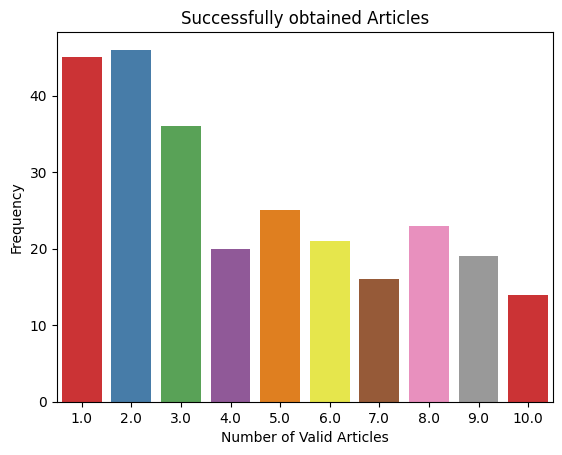

In [102]:
counts = df['First_Contradicting'].value_counts().reset_index()
counts.columns = ['Value', 'Count']  # Rename columns for clarity

# Create the barplot
sns.barplot(data=counts, x='Value', y='Count', palette='Set1')
plt.title('Successfully obtained Articles')
plt.xlabel('Number of Valid Articles')
plt.ylabel('Frequency')

### First vs. Last SERP Position

In [38]:
def retrieve_serp_results(feat_dict, position=1):
    if pd.isna(feat_dict):
        return np.nan
    
    stance_list = feat_dict['article_stances']
    serp_positions = feat_dict['article_serp_positions']
    
    if isinstance(position, list):
        results = [np.mean(stance_list[serp_positions.index(pos)]) for pos in position if pos in serp_positions]
        return np.nan if not results else np.mean(results)
    elif position in serp_positions:
        return np.mean(stance_list[serp_positions.index(position)])
    
    return np.nan

In [39]:
df['Stances_First'] = df['Features_Raw'].apply(lambda x: retrieve_serp_results(x, position=[1]))
df['Stances_Last'] = df['Features_Raw'].apply(lambda x: retrieve_serp_results(x, position=[10]))

In [41]:
df['Stances_First'].describe()

count    242.000000
mean       0.148926
std        0.319132
min       -1.000000
25%        0.000000
50%        0.120000
75%        0.400000
max        1.000000
Name: Stances_First, dtype: float64

In [42]:
df['Stances_Last'].describe()

count    165.000000
mean       0.103273
std        0.242952
min       -0.400000
25%        0.000000
50%        0.000000
75%        0.240000
max        1.000000
Name: Stances_Last, dtype: float64

In [43]:
pg.normality(data=df['Stances_First']) #not normally distributed
# pg.mwu(x=df.loc[df['Category'] == 'Misl', 'avg_score'],
#                 y=df.loc[df['Category'] == 'True', 'avg_score'],
#                 alternative='greater') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,W,pval,normal
Stances_First,0.940753,2.529963e-08,False


In [44]:
pg.normality(data=df['Stances_Last']) #not normally distributed

,W,pval,normal
Stances_Last,0.909639,1.454345e-08,False


In [45]:
#comparing last vs first against each other (not considering category)

In [46]:
pg.mwu(x=df['Stances_First'],
        y=df['Stances_Last'],
        alternative='greater') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,23521.5,greater,0.001058,0.178137,0.589068


In [47]:
df.groupby('Category')['Stances_First'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,124.0,0.116129,0.28300,-1.0,0.0,0.08,0.29,0.84
True,118.0,0.183390,0.35107,-1.0,0.0,0.20,0.44,1.00


In [48]:
pg.normality(data=df, dv='Stances_First', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_First'],
                y=df.loc[df['Category'] == 'True', 'Stances_First'],
                alternative='less') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,5877.0,less,0.004003,-0.196692,0.598346


In [49]:
df.groupby('Category')['Stances_Last'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,79.0,0.057722,0.233918,-0.36,-0.04,0.00,0.14,1.00
True,86.0,0.145116,0.244895,-0.40,0.00,0.04,0.28,0.68


In [50]:
pg.normality(data=df, dv='Stances_Last', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_Last'],
                y=df.loc[df['Category'] == 'True', 'Stances_Last'],
                alternative='less') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,2602.5,less,0.00407,-0.233883,0.616941


C:\Users\danie\AppData\Local\Temp\ipykernel_2152\4258603429.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_First', palette='Set1')


Text(0, 0.5, 'Stances Mean')

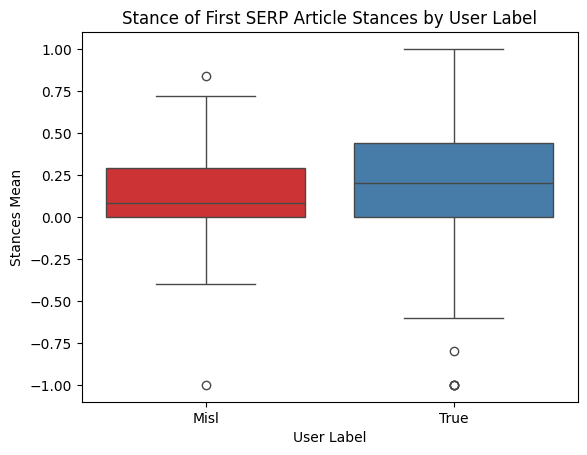

In [51]:
sns.boxplot(data=df, x='Category', y='Stances_First', palette='Set1')
plt.title('Stance of First SERP Article Stances by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

In [52]:
df['Stances_First'].describe()

count    242.000000
mean       0.148926
std        0.319132
min       -1.000000
25%        0.000000
50%        0.120000
75%        0.400000
max        1.000000
Name: Stances_First, dtype: float64

In [53]:
df['Stances_Last'].describe()

count    165.000000
mean       0.103273
std        0.242952
min       -0.400000
25%        0.000000
50%        0.000000
75%        0.240000
max        1.000000
Name: Stances_Last, dtype: float64

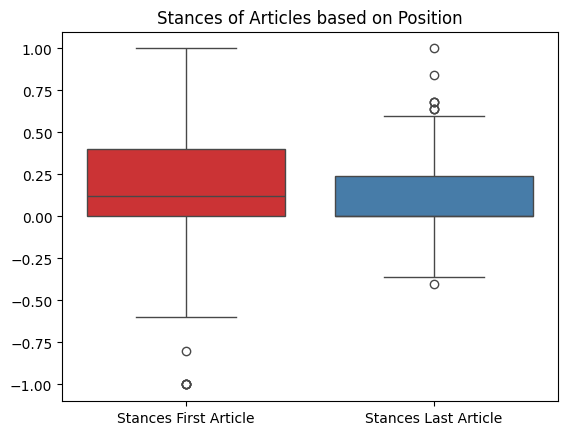

In [54]:
sns.boxplot(data=[df['Stances_First'], df['Stances_Last']], palette='Set1')
plt.title('Stances of Articles based on Position')
plt.xticks([0, 1], ['Stances First Article', 'Stances Last Article'])
plt.show()

In [55]:
df.groupby('Category')['Stances_Last'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,79.0,0.057722,0.233918,-0.36,-0.04,0.00,0.14,1.00
True,86.0,0.145116,0.244895,-0.40,0.00,0.04,0.28,0.68


C:\Users\danie\AppData\Local\Temp\ipykernel_2152\825327286.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Last', palette='Set1')


Text(0, 0.5, 'Stances Mean')

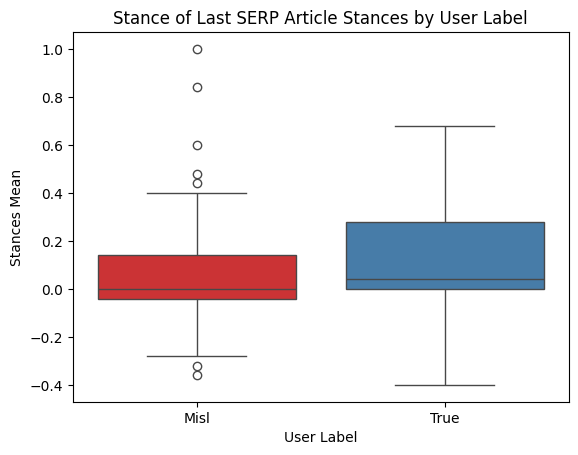

In [56]:
sns.boxplot(data=df, x='Category', y='Stances_Last', palette='Set1')
plt.title('Stance of Last SERP Article Stances by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

### Median

In [57]:
df['Stances_Median'] = df['Features_Raw'].apply(lambda x: transform_stances(x, method=np.median))

In [58]:
df['Stances_Median'].describe()

count    595.000000
mean       0.106918
std        0.248738
min       -1.000000
25%        0.000000
50%        0.080000
75%        0.260000
max        1.000000
Name: Stances_Median, dtype: float64

In [59]:
df.groupby('Category')['Stances_Median'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,0.074843,0.236080,-0.8,-0.02,0.00,0.20,0.76
True,295.0,0.139537,0.257302,-1.0,0.00,0.12,0.31,1.00


In [60]:
df.groupby('num_valid_articles')['Stances_Median'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,105.0,0.147429,0.351888,-1.00,0.00,0.12,0.440000,1.00
2,137.0,0.113066,0.279699,-1.00,0.00,0.08,0.320000,0.72
3,114.0,0.102398,0.209916,-0.80,0.00,0.08,0.266667,0.48
4,97.0,0.051782,0.159106,-0.30,-0.02,0.02,0.140000,0.46
5,67.0,0.113731,0.158982,-0.32,0.00,0.08,0.200000,0.56
6,50.0,0.088600,0.221147,-0.48,-0.04,0.02,0.220000,0.62
7,17.0,0.121176,0.226326,-0.40,0.00,0.04,0.300000,0.48
8,6.0,0.313333,0.171425,0.08,0.20,0.32,0.425000,0.54
9,2.0,-0.020000,0.084853,-0.08,-0.05,-0.02,0.010000,0.04


C:\Users\danie\AppData\Local\Temp\ipykernel_2152\2000799094.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Median', palette='Set1')


Text(0, 0.5, 'Stances Median')

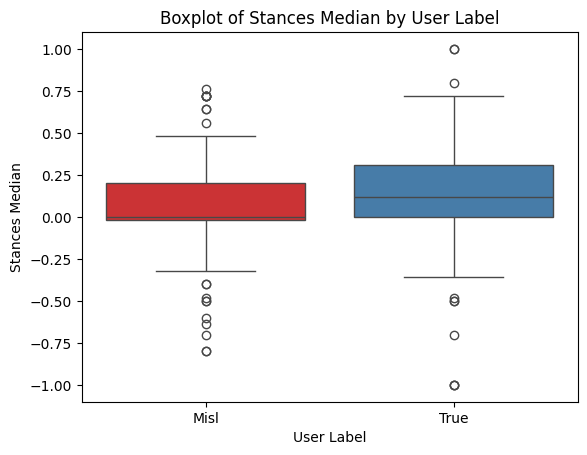

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(data=df, x='Category', y='Stances_Median', palette='Set1')
plt.title('Boxplot of Stances Median by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Median')

## Stances w/ Positions

### Mean

In [62]:
df['Stances_Pos_Mean'] = df['Features_Pos'].apply(lambda x: transform_stances(x, method=np.mean))

In [63]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(-1, 1))
# df['Stances_Pos_Mean'] = scaler.fit_transform(np.array(df['Stances_Pos_Mean']).reshape(-1, 1)).flatten()

In [64]:
df['Stances_Pos_Mean'].describe()

count    595.000000
mean       0.110435
std        0.265344
min       -1.051961
25%       -0.018654
50%        0.072826
75%        0.254797
max        1.311765
Name: Stances_Pos_Mean, dtype: float64

In [65]:
df.groupby('Category')['Stances_Pos_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,0.068827,0.231332,-0.876371,-0.043623,0.030157,0.203577,0.872332
True,295.0,0.152748,0.290284,-1.051961,0.000000,0.136407,0.337488,1.311765


In [66]:
df.groupby('num_valid_articles')['Stances_Pos_Mean'].describe()


,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,105.0,0.149067,0.363327,-1.051961,0.000000,0.078881,0.336364,1.311765
2,137.0,0.109790,0.286027,-1.051961,0.000000,0.069315,0.278853,0.872332
3,114.0,0.098474,0.223160,-0.876371,-0.001512,0.063778,0.252389,0.537424
4,97.0,0.067965,0.177569,-0.466434,-0.042246,0.044003,0.178884,0.608268
5,67.0,0.101703,0.186441,-0.310055,-0.041306,0.083332,0.215512,0.482327
6,50.0,0.109930,0.268550,-0.559411,-0.073110,0.031509,0.306751,0.741479
7,17.0,0.138208,0.289163,-0.366384,0.003677,0.043283,0.384485,0.566020
8,6.0,0.405284,0.218960,0.140415,0.219251,0.431033,0.562115,0.674759
9,2.0,0.052597,0.112423,-0.026898,0.012849,0.052597,0.092345,0.132092


In [67]:
pg.normality(data=df, dv='Stances_Pos_Mean', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_Pos_Mean'],
                y=df.loc[df['Category'] == 'True', 'Stances_Pos_Mean'],
                alternative='less')

,U-val,alternative,p-val,RBC,CLES
MWU,34636.5,less,0.000002,-0.217254,0.608627


C:\Users\danie\AppData\Local\Temp\ipykernel_2152\4211040222.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_Pos_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

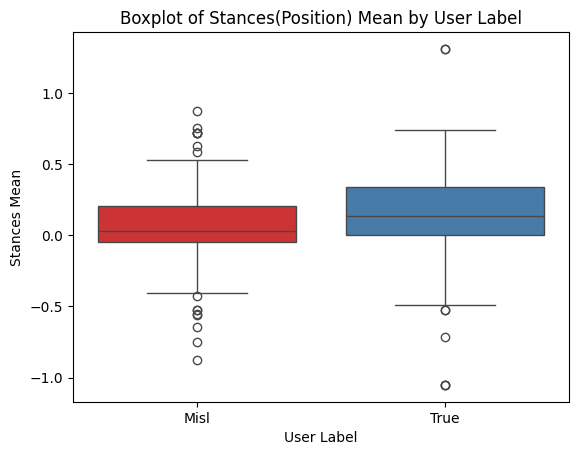

In [68]:
sns.boxplot(data=df, x='Category', y='Stances_Pos_Mean', palette='Set1')
plt.title('Boxplot of Stances(Position) Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

In [69]:
last_search_df = df.drop_duplicates(subset='ResponseId', keep='last')
last_search_df.groupby('Category')['Stances_Pos_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,123.0,0.053369,0.237068,-0.876371,-0.066944,0.043283,0.182674,0.717274
True,142.0,0.162543,0.307195,-1.051961,0.000000,0.136671,0.392641,1.311765


## Stances w/ Headlines

### Mean

In [70]:
df['Stances_H_Mean'] = df['Features_H'].apply(lambda x: transform_stances(x, method=np.mean))

In [71]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(-1, 1))
# df['Stances_H_Mean'] = scaler.fit_transform(np.array(df['Stances_H_Mean']).reshape(-1, 1)).flatten()

In [72]:
df['Stances_H_Mean'].describe()

count    595.000000
mean       0.016804
std        0.076590
min       -0.300000
25%        0.000000
50%        0.000000
75%        0.025833
max        1.000000
Name: Stances_H_Mean, dtype: float64

In [73]:
df.groupby('Category')['Stances_H_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,0.012224,0.057989,-0.173333,0.0,0.0,0.020000,0.52
True,295.0,0.021461,0.091590,-0.300000,0.0,0.0,0.026667,1.00


In [74]:
import pingouin as pg
pg.normality(data=df, dv='Stances_H_Mean', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_H_Mean'],
                y=df.loc[df['Category'] == 'True', 'Stances_H_Mean'],
                alternative='less') #Mann-Whitney U (testing if Misl (Group 1) is less than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,U-val,alternative,p-val,RBC,CLES
MWU,39397.0,less,0.006848,-0.109672,0.554836


In [75]:
df.groupby('num_valid_articles')['Stances_H_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,105.0,0.026667,0.144293,-0.160000,0.000000,0.000000,0.000000,1.000000
2,137.0,0.019124,0.078098,-0.300000,0.000000,0.000000,0.020000,0.520000
3,114.0,0.007057,0.021087,-0.066667,0.000000,0.000000,0.022222,0.053333
4,97.0,0.018754,0.053092,-0.050000,0.000000,0.000000,0.030000,0.250000
5,67.0,0.012816,0.029383,-0.064000,0.000000,0.008000,0.032000,0.112000
6,50.0,0.010960,0.036933,-0.173333,0.000000,0.000000,0.033333,0.066667
7,17.0,0.013053,0.028666,-0.057143,0.000000,0.011429,0.028571,0.057143
8,6.0,0.042500,0.017819,0.025000,0.031250,0.040000,0.045000,0.075000
9,2.0,0.035556,0.018856,0.022222,0.028889,0.035556,0.042222,0.048889


C:\Users\danie\AppData\Local\Temp\ipykernel_2152\3702187806.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_H_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

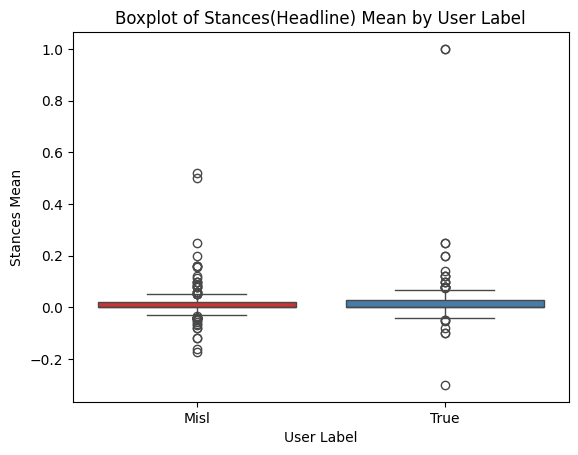

In [76]:
sns.boxplot(data=df, x='Category', y='Stances_H_Mean', palette='Set1')
plt.title('Boxplot of Stances(Headline) Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

## Stances w/ Headlines and Pos

In [77]:
df['Stances_HP_Mean'] = df['Features_HP'].apply(lambda x: transform_stances(x, method=np.mean))

In [78]:
df['Stances_HP_Mean'].describe()

count    595.000000
mean       0.130348
std        0.324515
min       -1.051961
25%       -0.021919
50%        0.082854
75%        0.299202
max        2.623529
Name: Stances_HP_Mean, dtype: float64

In [79]:
df.groupby('Category')['Stances_HP_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,0.081979,0.275492,-0.956641,-0.052985,0.028222,0.218865,1.546845
True,295.0,0.179536,0.361617,-1.051961,0.000000,0.157397,0.354452,2.623529


In [80]:
df.groupby('num_valid_articles')['Stances_HP_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
num_valid_articles,,,,,,,,
1,105.0,0.181893,0.485070,-1.051961,0.000000,0.080000,0.336364,2.623529
2,137.0,0.130961,0.343547,-1.051961,0.000000,0.084371,0.326667,1.546845
3,114.0,0.105073,0.238739,-0.956641,-0.012425,0.076451,0.267079,0.564805
4,97.0,0.090666,0.220919,-0.466434,-0.052952,0.073774,0.187497,0.741793
5,67.0,0.116113,0.215979,-0.310055,-0.051091,0.121035,0.250966,0.611123
6,50.0,0.125457,0.309340,-0.795390,-0.093859,0.031910,0.347352,0.841438
7,17.0,0.157473,0.320845,-0.400785,0.008495,0.077656,0.375673,0.640043
8,6.0,0.470368,0.221484,0.170997,0.316756,0.481655,0.627702,0.749728
9,2.0,0.095954,0.135932,-0.000164,0.047895,0.095954,0.144013,0.192073


In [81]:
pg.normality(data=df, dv='Stances_HP_Mean', group='Category') #not normally distributed
pg.mwu(x=df.loc[df['Category'] == 'Misl', 'Stances_HP_Mean'],
                y=df.loc[df['Category'] == 'True', 'Stances_HP_Mean'],
                alternative='less')

,U-val,alternative,p-val,RBC,CLES
MWU,34604.0,less,0.000002,-0.217989,0.608994


C:\Users\danie\AppData\Local\Temp\ipykernel_2152\1375276248.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Stances_HP_Mean', palette='Set1')


Text(0, 0.5, 'Stances Mean')

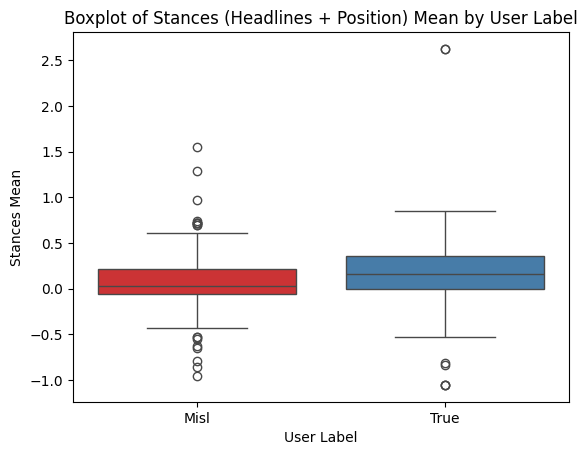

In [82]:
sns.boxplot(data=df, x='Category', y='Stances_HP_Mean', palette='Set1')
plt.title('Boxplot of Stances (Headlines + Position) Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('Stances Mean')

# Newsguard Score

In [83]:
def transform_newsguard(feat_dict, method):
    if pd.isna(feat_dict):
        return np.nan
    article_ng_scores = feat_dict['article_ng_scores']
    article_ng_scores = np.nan_to_num(article_ng_scores, nan=0)
    return method(article_ng_scores)

In [84]:
df['Newsguard_Mean'] = df['Features_Raw'].apply(lambda x: transform_newsguard(x, method=np.mean))

In [85]:
df.groupby('Category')['avg_score'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,87.583861,12.877383,23.5,86.914683,92.185065,95.000000,100.0
True,295.0,86.409363,13.170393,5.0,84.718750,90.562500,94.058333,100.0


In [86]:
pg.normality(data=df, dv='avg_score', group='Category') #not normally distributed
# pg.mwu(x=df.loc[df['Category'] == 'Misl', 'avg_score'],
#                 y=df.loc[df['Category'] == 'True', 'avg_score'],
#                 alternative='greater') #Mann-Whitney U (testing if Misl (Group 1) is higher than True (Group 2) -> differences statistically significant, but with a small effect size (RBC < 0.3)

,W,pval,normal
Category,,,
Misl,0.719969,4.095464e-22,False
True,0.748896,7.084357e-21,False


This is the NewsGuard Score of the retrieved articles. For the final calculation, we instead use the average NG score given above.

C:\Users\danie\AppData\Local\Temp\ipykernel_2152\3465771059.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Newsguard_Mean', palette='Set2')


Text(0, 0.5, 'NG Mean')

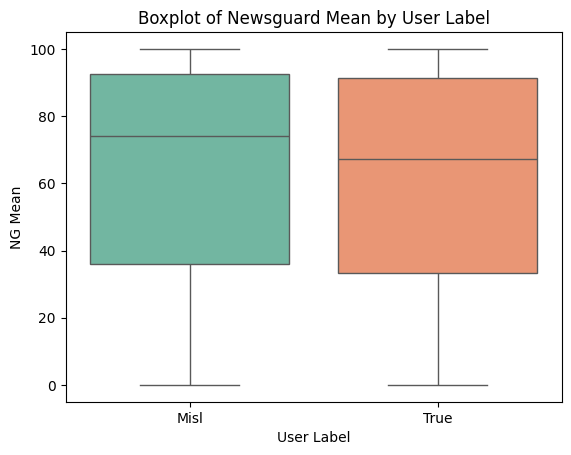

In [87]:
sns.boxplot(data=df, x='Category', y='Newsguard_Mean', palette='Set2')
plt.title('Boxplot of Newsguard Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('NG Mean')

# Article SERP Position

## Mean Rank

In [88]:
def transform_serp_position(feat_dict, method):
    if pd.isna(feat_dict):
        return np.nan
    article_serp_positions = feat_dict['article_serp_positions']
    article_serp_positions = np.nan_to_num(article_serp_positions, nan=0)
    return method(article_serp_positions)

In [89]:
df['SERP_Position_Mean'] = df['Features_Raw'].apply(lambda x: transform_serp_position(x, method=np.mean))

In [90]:
df.groupby('Category')['SERP_Position_Mean'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Misl,300.0,5.211726,1.955638,1.0,4.0,5.0,6.333333,10.0
True,295.0,4.916636,1.976339,1.0,3.9,5.0,6.166667,9.5


C:\Users\danie\AppData\Local\Temp\ipykernel_2152\3667827325.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='SERP_Position_Mean', palette='Set3')


Text(0, 0.5, 'NG Mean')

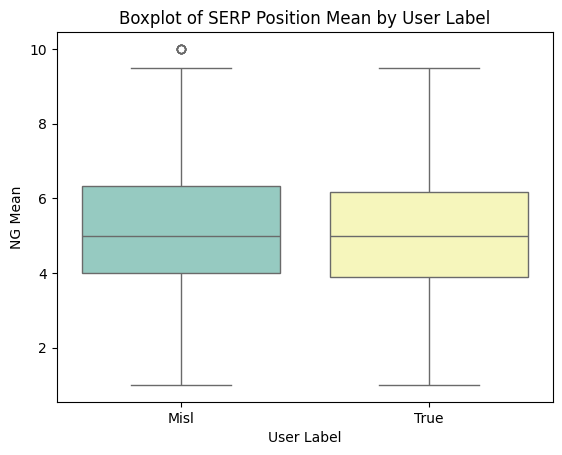

In [91]:
sns.boxplot(data=df, x='Category', y='SERP_Position_Mean', palette='Set3')
plt.title('Boxplot of SERP Position Mean by User Label')
plt.xlabel('User Label')
plt.ylabel('NG Mean')